# Building Makemore

[Video](https://www.youtube.com/watch?v=PaCmpygFfXo)<br>
[Repository](https://github.com/karpathy/makemore)<br>
[Eureka Labs Discord](https://discord.com/invite/3zy8kqD9Cp)

## Table of Contents

- [Goal](#Goal)
- [The Bigram Language Model](#The-Bigram-Language-Model)
    - [Visualizing the Bigram Model](#Visualizing-the-Bigram-Model)
    - [Addressing Impossibilities](#Addressing-Impossibilities)
    - [Building Probability Distributions](#Building-Probability-Distributions)
    - [Sampling from Probability Distributions](#Sampling-from-Probability-Distributions)
    - [Quality of Generated Names](#Quality-of-Generated-Names)
    - [Model Smoothing](#Model-Smoothing)
- [Neural Network Approach - Same Problem, Different Solution](#Neural-Network-Approach---Same-Problem,-Different-Solution)
    - [Feeding the Network](#Feeding-the-Network)
    - [Regaining Normal Distributions](#Regaining-Normal-Distributions)
    - [Recap](#Recap)
    - [Optimization](#Optimization)
    - [Backward Pass](#Backward-Pass)
- [Summary](#Summary)

## Goal

Makemore takes a text file (like the provided `names.txt`), where each line is assumed to be one training "thing".<br>
It then generates more "things" like that.

Under the hood, Makemore is a **character-level language model**.<br>
Every single line contains an example, a sequence of words, of individual characters.<br>
The latter is the level Makemore operates on, trying to predict the next character in a sequence.

> Makemore is a character-level language model that is implemented in a modern way.

**Our goal is to build Makemore from scratch and understand how it works.**

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available (faster calculations with PyTorch)

In [2]:
words = open('../names.txt', 'r').read().splitlines()   # Python list of strings

print("First 10 names: ", words[:10])   # First ten names, each as separate string
print("Dataset size: ", len(words))     # Amount of words in dataset
print("Shortest name: ", min(len(w) for w in words))    # Smallest word in dataset
print("Longest name: ", max(len(w) for w in words))     # Longest word in dataset

First 10 names:  ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Dataset size:  32033
Shortest name:  2
Longest name:  15


With the character-level approach, **each of the above names is actually a sequence of examples of which character follows which**,<br>
which character might come first, how many characters there are in character sequences in total, etc.

## The Bigram Language Model

The Bigram approach to language modelling follows the idea of processing *just two* neighboring characters at a time.<br>
It really only works on these local subsequences, effectively ignoring more information that might be present in an overall character sequence (a name in our case).

It's a great place to start.

In [3]:
for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat two char 'sliding-window'
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>


This returns `<S>e, em, mm, ma, a<E>` for the name `emma`.

A model may now interpret that an `m` is likely to follow an `e`, while `a` is likely to conclude a name and so on.<br>
Note that `<S>` and `<E>` are what we call 'special characters', which we added to denote the beginning and the end of a name.<br>
Putting it differently, we very explicitly add 'special characters' to show start and end, and by doing so, this makes for an additional character pair each.<br><br>
The simplest way to derive statistics on which characters follow which is to just count the combinations present in the training set.<br>We need a dictionary for that.

In [4]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat way for two char 'sliding-window'
        bigram = (ch1, ch2) # bigram is the (ch1, ch2) tupel
        b[bigram] = b.get(bigram, 0) + 1 # If tupel count not ex. -> 0 + 1

Dictionary `b` now contains the accumulations/'statistics' of letter combinations in the entire dataset.<br>
Let's look into that.

In [5]:
# b.items() returns tupels like (('<S>', a), 34)
# sorted() would sort items by tupel, not amount
# to sort by amount: lambda function replaces key with value (amount) high->low
sorted(b.items(), key = lambda keyvalue: -keyvalue[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

For example, the most likely / most often encountered combination in our `names.txt` is `(('n', '<E>'), 6763)`.<br>
It is actually more convenient to keep this information in a 2D array, rather than this dictionary.<br>
That way, we can easily access the amount of occurrences of a character pair while maintaining a uniform structure.

So, we should build that 2D array/matrix in such a way that 
- the **rows are the first characters** and 
- the **columns are the second characters**

Within this table, a cell holds the amount of occurrences per row and column.<br>
For data handling and processing, we use **PyTorch**.<br>
We have $26$ letters **+2** special characters. This makes for a $28\times 28$ array.

In [6]:
N = torch.zeros((28,28), dtype=torch.int32) # datatype would otherwise be float32 by default

# Problem: We'll have only chars, but below we index using ints -> Need for mapping
chars = sorted(list(set(''.join(words)))) # set(): Throwing out letter duplicates

# A mapping from letter to number
stoi = {s:i for i,s in enumerate(chars)}
stoi['<S>'] = 26
stoi['<E>'] = 27

# Copied from above, but now modified for mapping
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    # Neat way for two char 'sliding-window'
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1 # Increment cell in 2D by 1

### Visualizing the Bigram Model

If we would visualize this `N` numerically, it would look like a total mess. So, let's use `matplotlib`.

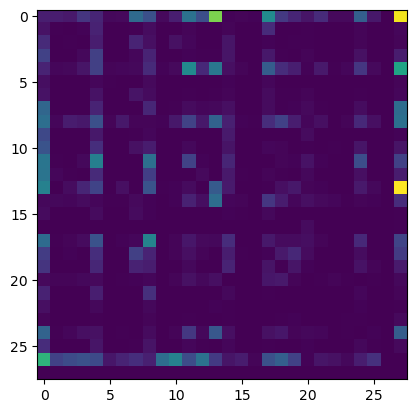

In [7]:
plt.imshow(N);

This still looks kind of ugly.<br>
Let's build something even nicer to visualize what's going on.

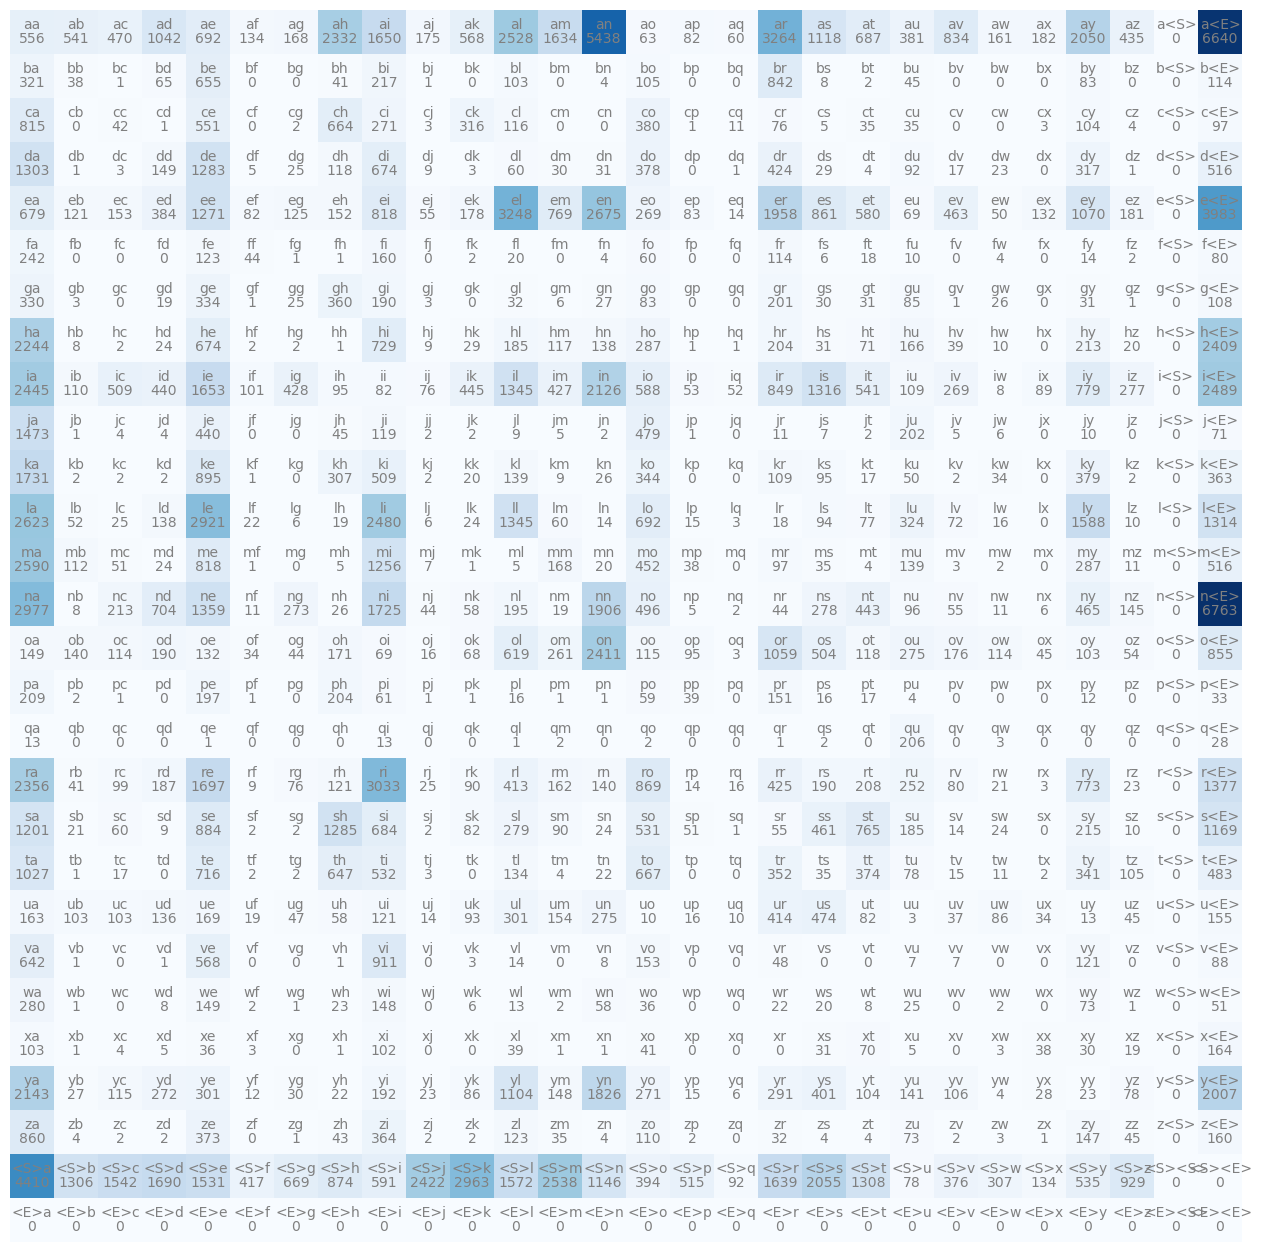

In [8]:
itos = {i:s for s, i in stoi.items()} # Basically reversing stoi element order

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues') # Heatmap basically
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j] # Add text for heat tiles
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis('off');

### Addressing Impossibilities

If you render this, there will be a row and a column that show a problem with `<S>` and `<E>`.<br>
There is a column for instances like `(a, <S>)` (second to last) and a row for tupels like `(<E>, a)` (last). <br>**Impossible combinations.**

> This problem is so grave that we should adapt our model.<br>This is done through replacing our special `<S>` and `<E>` with only one special, common character: `.`

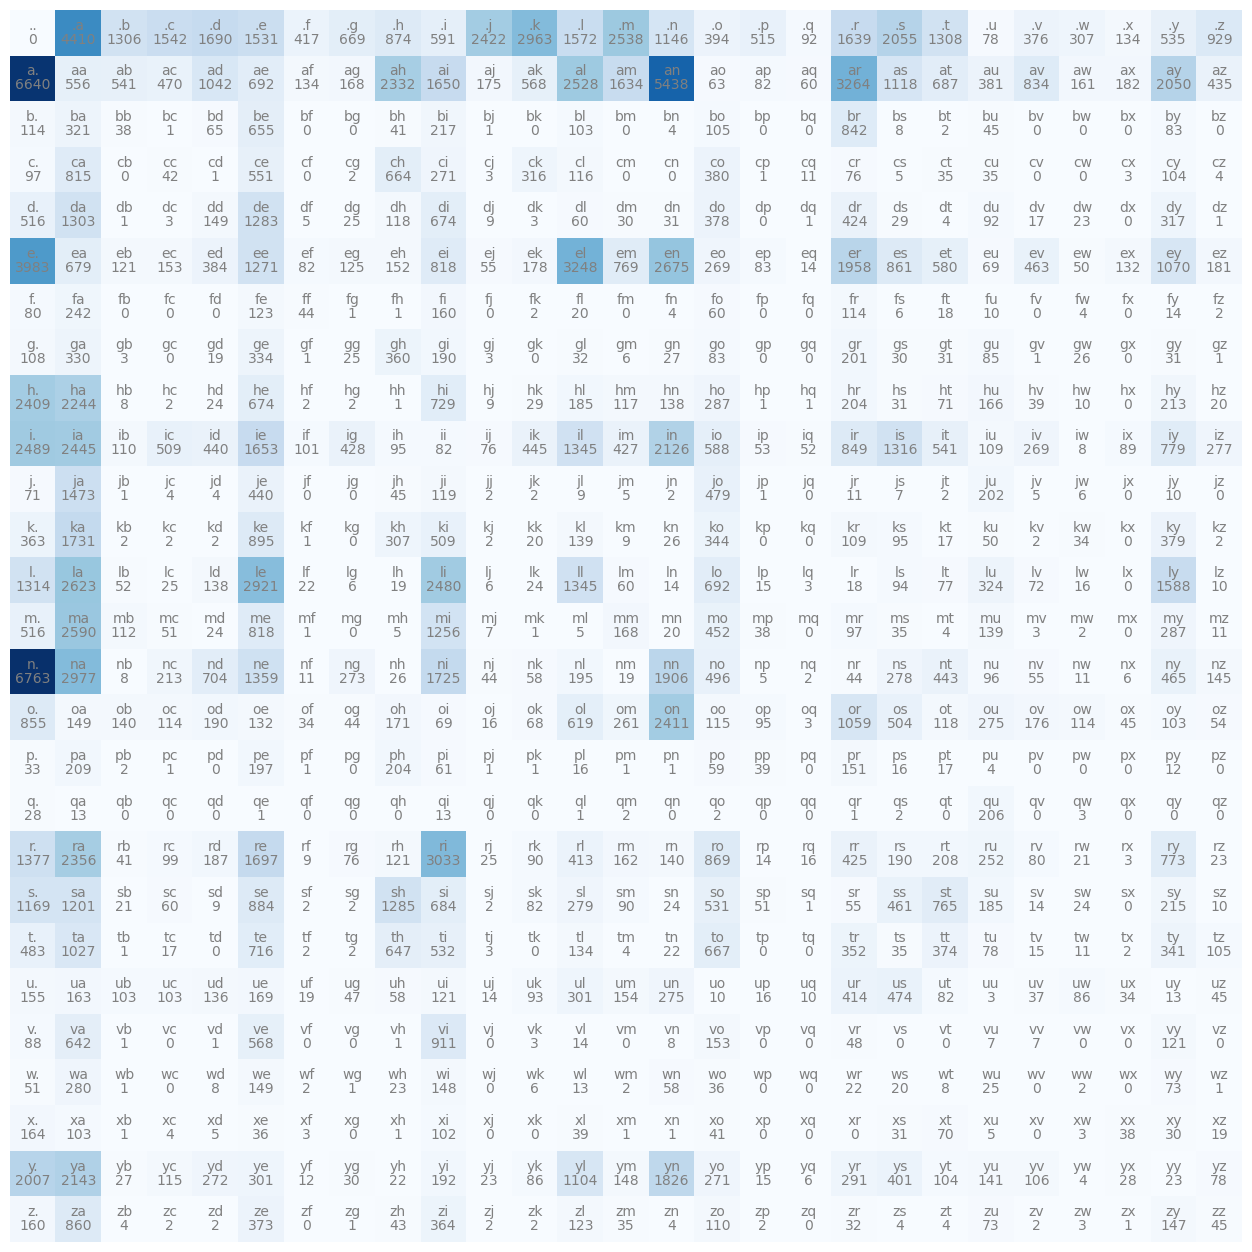

In [9]:
N = torch.zeros((27, 27), dtype=torch.int32) # 28x28 -> 27x27

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # Our special character now has position zero
itos = {i:s for s,i in stoi.items()}

# Copied from above, but now modified
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat way for two char 'sliding-window'
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1 # Increment cell in 2D by 1

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues') # Heatmap basically
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j] # Add text for heat tiles
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis('off');

This removes the redundant column-row problem from before, as `'.'` in fact now *can* occur in front or after letters<br>(even `..` is legal, technically).

### Building Probability Distributions

We will follow the probabilities and start sampling the model, line by line as shown by the correlation matrix.<br>So, we start with tupels of the line containing `('.', 'a')`.

In [10]:
# Getting the entire zero-th row 
# (a 1D array of '.' and all letters following)
print("Raw first row's combination counts:\n", N[0], "\n")
print(N[0].shape)

Raw first row's combination counts:
 tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32) 

torch.Size([27])


Since we want to sample, we need to convert the raw counts row-wise into probabilities.<br>
We do this by dividing each cell by the sum of its row's cells. This way, we get a probability distribution for this row.

In [11]:
p = N[0].float() # probability vector (np.array of floats)
p = p / p.sum()  # normalized probability distribution

print("First Row's distribution:\n", p)

First Row's distribution:
 tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


Let's play with the meaning behind `p` and what could be done with it now.

In [12]:
# Sampling from these distributions
# Torch.multinomial -> "Give me probability, I'll give you integer"
# We'll use a PyTorch Generator to make things random yet repeatable (deterministic)
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g) # Generate three random numbers [0;1]
p = p / p.sum()  # compact these random numbers into a distribution

# output: [0.6064, 0.3033, 0.0903]
print(p)

tensor([0.6064, 0.3033, 0.0903])


### Sampling from Probability Distributions

To now sample from this distribution, we can use `torch.multinomial()`.<br>
This takes a probability distribution and provides a number of integers sampled with the given probability distribution.

In [13]:
# With probability distribution p, create a list of 20 samples
# [replacement: true] means drawing an element doesn't invalidate drawing this element again
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

# We'd expect ~60% of the 20 items to be 0, ~30% to be 1 , ~10% to be 2
# output: [1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

> The larger the sample size, the more precise the distribution can be approximated/matched.

We now use the same generator and apply the sampling logic to our 2D occurrences array. (or rather its first row)<br>
We take the counts per row, compact them into a normal distribution and draw **one** sample from that.

In [14]:
p = N[0].float() # probability vector
p = p / p.sum()  # normalized probability distributions

g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

# This is an index, a number representing a letter by probability
print(itos[ix]) # Convert index to letter

j


We just drew a starting character/token `'j'` for our first name suggestion.<br>
With that, we can move through the array to find the row of entries with row name `('j', '.')` and repeat the drawing process.

**This is a probability-driven loop from now on.**

In [15]:
g = torch.Generator().manual_seed(2147483647)
n = 20

for i in range(n):
    ix = 0   # Start with special ('.', 'letter') token row
    out = [] # hold the n names to be generated
    while True:
        p = N[ix].float() # probability vector
        p = p / p.sum()   # normalized probability distributions
        # draw a single sample from this distribution, set this as new row index
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        # if we find ourselves back in the special ('.', 'letter') row, we're done with this name
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


Et voilà, terrible name suggestions appear.<br>
Even though it's doing terribly, *it is doing reasonably*. Inefficiently though. Let's fix that.

With `p = N[ix].float() # probability vector` we're always fetching a row and always convert this row entirely from int to float.<br>
Moreover, every iteration we also do `p = p / p.sum()`.<br>
It would be better to prepare a dedicated, preprocessed matrix `P` for this; just a matrix of calculated probabilities.<br>
As a side-step, we use `P` to sum up itself row-wise. This was `p.sum()` for all the 27 letters before.

Let's build this performance upgrade matrix `P`:

In [16]:
P = N.float()
# P /= P.sum() # This would sum over all elements, row- and column-wise -> wrong
# This is allowed with PyTorch:
P /= P.sum(1, keepdims=True) # sum: A 27x1 vector (1 stands for row-wise sum) (27 by 27 divided by 27 by 1 is possible in PyTorch -> broadcasting)
# For broadcasting to work like here, each dimension must be either equal or 1 (or not existent), which is the case here (dimensions will be aligned from right to left!)
# Keepdim=True means that the sum vector is 27x1, (the 1 before that stating that the no. of rows is to be kept, but columns are to be summed over per row)

g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    ix = 0
    out = [] # Hold multiple names
    while True:
        p = P[ix]
        # draw a single sample from this distribution
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        # If stopping special character is drawn
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


In [17]:
# Quick sanity check for broadcasting
# Expected: Every row of P should sum up to 1
print(P.sum(1)) # 1 stands for row-wise sum

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


It is at this point strongly advised to read through [PyTorch Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html). **Really understand it, don't skim it.**

> Broadcasting might accept things and process them in ways that you didn't intend.<br>You *really* need to understand your use of broadcasting to know whether you made a mistake in the process.<br>Because most of the time, it will *not* tell you.

### Quality of Generated Names

We have built a bigram language model by counting letter combination frequencies and then normalizing and sampling with that probability base.<br>
We trained the model, we sampled from the model (iteratively, character-wise). But its still bad at coming up with names.<br>
But how bad? We know that the model's "knowledge" is represented by `P`, but how can we boil down the model's quality in one value?

First, let's look at the bigrams we created from the dataset:<br>
The bigrams to `emma` are e.g.: `.e, em, mm, ma, a.`<br>
**What probability does the model assign to each of those bigrams?**

In [18]:
# Copied from above, but now modified
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat way for two char 'sliding-window'
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        print(f'{ch1}{ch2}: {prob:.4f}')

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960


This provides outputs like `ma: 0.3899`.<br>
Anything above or below $\frac{1}{27} = 0.0370$ means we deviate from the mean / we learned something (does not need to be constructive) from the bigram statistics.<br>
We learned this, again, by counting the occurrences of each bigram in the dataset of names, then normalizing the counts to probabilities.

Ok, now how can we summarize these probabilities into a quality indicating measurement?<br>
Solution: *The Log-Likelihood, the **sum** of $\ log(probability)$ over all the individual token probabilities* ($log$ is applied for readability, basically for convenience)<br>

> The higher the Log-Likelihood, the better the model, because the more capable it is of predicting the next character in a sequence from the dataset.

In [19]:
log_likelihood = 0.0
n = 0 # tuple count

# copied from above, but now modified - Log likelihood over all words
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat way for two char 'sliding-window'
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}') # As this is a tensor and we want to see that too
nll = -log_likelihood
print(f'{nll=}')            # Negative log likelihood
print(f'{nll/n}')           # Average negative log likelihood (this is the loss we want to minimize)

log_likelihood=tensor(-559891.7500)
nll=tensor(559891.7500)
2.454094171524048


We calculated a negative Log-Likelihood, because this follows the convention of setting the goal to minimize the loss function. The lower the loss/negative Log-Likelihood, the better the model.

> The worse/smaller the probability, the more negative the Log-Likelihood. This is why it is inverted into positive space. **The higher the negative Log-Likelihood `nll`, the worse the model.**<br>
> Often this `nll` then is normalized as well, resulting in the **average (negative) log-likelihood**.

We got $2.45$ for the model. The lower, the better.<br>
We need to find the parameters that reduce this value.

**Goal:**<br>
Maximize likelihood of the trained data w. r. t. model parameters in `P`<br>
- this is equivalent to: Maximizing the log-likelihood (as $log$ is monotonic)
- this is equivalent to: Minimizing the *negative* log-likelihood
- and this is equivalent to: Minimizing the average negative log-likelihood (the quality-measurement, as shown by $2.45$ above)

Problems with our model can from now on be visualized by looking at our loss function, the negative log-likelihood.<br>One such problem prompty occurs below:

In [20]:
log_likelihood = 0.0
n = 0

# Copied from above, but now modified
for w in ['andrejq']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat way for two char 'sliding-window'
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'\n{log_likelihood=}') # As this is a tensor and we want to see that too
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

.a: 0.1377 -1.9829
an: 0.1605 -1.8296
nd: 0.0384 -3.2594
dr: 0.0771 -2.5620
re: 0.1336 -2.0127
ej: 0.0027 -5.9171
jq: 0.0000 -inf
q.: 0.1029 -2.2736

log_likelihood=tensor(-inf)
nll=tensor(inf)
inf


With the name `andrejq` we get an average negative log-likelihood of $\infty$. An infinite loss, the "worst case" model performance.<br>
This is because the bigram `jq` was never present in our training data, its count is just $0$, the likelihood therefore is $0\%$<br>
The likelihood for the model choosing this is therefore $log(0) = -\infty$, massively distorting the negative log-likelihood.

Kinda gross.

### Model Smoothing

Model Smoothing addresses this relatively easily.<br>
We basically increment every count we have by $1$ to avoid a count of $0$:

In [21]:
P = (N+1).float() # Adding a lot more means smoothing out distributions more; see NN approach for discussing this
# This is allowed with PyTorch:
P /= P.sum(1, keepdims=True) # sum: A 27x1 vector (1 stands for row-wise sum)

We add `+1` to `N`, so we avoid $\infty$ caused by $log$.<br>
Re-Running the exact same code as before smoothing now gives the bigram `jq` a (very small) probability.

> The model was surprised by this bigram, but not overwhelmed anymore.

In [22]:
log_likelihood = 0.0
n = 0

# Copied from above, but now modified
for w in ['andrejq']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # Neat way for two char 'sliding-window'
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
print(f'{log_likelihood=}') # As this is a tensor and we want to see that too
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-27.8672)
nll=tensor(27.8672)
3.4834020137786865


**This is quite a solid bigram character estimation model up until now.**<br>
**We've evaluated the performance and removed loopholes through smoothing.**<br>
**It's still somewhat wobbly.**

---

## Neural Network Approach - Same Problem, Different Solution

**Now**, we will cast the problem of character estimation into the framework of Neural Networks.<br>
The problem as we tackled it remains the same, the approach changes, the outcome should look similar.

Our neural network **receives a single character** and **outputs the probability distribution over the next possible characters**<br>($27$ in this case).<br><br>
It's going to make guesses on the most likely character to follow.<br>
This will *still* be measurable in performance through the *same* loss function, the negative log-likelihood.<br>
As we have the training data, we know the character that actually comes next per training example.<br>This can be utilized for tuning the neural network to make better guesses. **Supervised Learning in action.**

In [23]:
#Create training set of all bigrams
xs, ys = [], [] # Input and output character indices

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

# Convert lists to tensors
xs = torch.tensor(xs)
ys = torch.tensor(ys) 

With name `.emma.`, `xs` and `ys` would look like this:

In [24]:
#Create training set of one particular bigram
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(f'{ch1}{ch2}: {ix1} -> {ix2}')
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(xs)
print(ys)

.e: 0 -> 5
em: 5 -> 13
mm: 13 -> 13
ma: 13 -> 1
a.: 1 -> 0
tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


> There exist `torch.tensor` and also `torch.Tensor`. Which one should be used?

(From [here](https://stackoverflow.com/questions/51911749/what-is-the-difference-between-torch-tensor-and-torch-tensor)) Every PyTorch Tensor is an instance of `torch.Tensor`, but `torch.tensor` is a function that constructs and returns a `torch.Tensor` instance.<br>
Except for when initializing a completely empty tensor, in general there is no reason to choose `torch.Tensor` over `torch.tensor`.<br>
It should also be noted that `torch.Tensor` is an alias for `torch.FloatTensor`, the default dtype therefore would be `torch.float32`.

**It is thoroughly recommended to use `torch.tensor`.**

### Feeding the Network

It does not make sense to use the numeric representations of letters as the input to a single input neuron.<br>
The network would refer to the numeric value itself, without any reference to potential context like possible value range etc.<br>
The letter associated with a number is in its indexed position due to its relation to other letters though. This would not be expressed.<br>
**One-Hot Encoding** would be much better with that.

> With One-Hot Encoding, we take the letter's integer value, e.g. $13$, and we create a vector that is all $0$, except for the $13^{th}$ position. There we place a $1$.

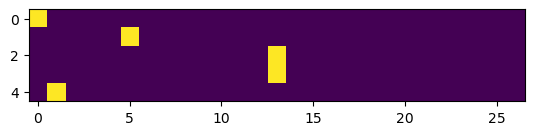

In [25]:
xenc = F.one_hot(xs, num_classes=27).float() # num_classes removes the need for F's guessing
xenc.shape # For '.emma' this will be [5, 27]
plt.imshow(xenc); # '. e m m a' (remember, this is the input, output would be 'e m m a .' for this example)

The word's characters were mapped to integer and now to vectors of type `float32`. <br>
And that in turn means, they can be an input for NNs.

Let's experiment with neurons. We build one $27$-dimensional neuron and approach it with the letter-wise input of our first name `.emma` (That's $5$ letters)

In [26]:
W = torch.randn((27,1), generator=g) # the neuron: random column vector of 27 numbers from normal distribution
a = xenc @ W  # '@' is PyTorch's matrix multiplication operator (5x27 @ 27x1 -> 5x1)

print(a) # this is now a 5x1 vector

tensor([[ 0.1066],
        [-1.2464],
        [-0.6378],
        [-0.6378],
        [ 1.8598]])


`W` is a **single** neuron.<br>
Multiplying it by `xenc` makes it 'react' to the one-hot encoded input. The result is a $5\times 1$ vector. <br>
`.emma` has $5$ characters, we have $1$ neuron.<br>
The vector shows the activation of the neuron per character; its reaction to the characters so to say.

>As the input was one-hot encoded, the single neuron takes in a "character of the width $27$".<br>
>In this example, it does so for all $5$ letters *at once*. Per $27$-dimensional letter, it outputs exactly one activation.<br>
>It doesn't learn from that, but this is the general idea.<br>
>The key insight is that **as a letter has $27$ dimensions through One-Hot Encoding, a single neuron has to have $27$ dimensions as well.**

Now, this was only **one** neuron. We want $27$ neurons. The reason for 'one neuron per possible character' will become obvious later on.

In [27]:
W = torch.randn((27,27), generator=g) # random column matrix of 27x27 numbers (previous was 27x1 for a single neuron)
a = xenc @ W  # @ is PyTorch's matrix multiplication operator, this is now a 5x27 vector

print(a) # this is now a 5x27 vector

tensor([[ 0.2603,  0.9090, -1.4458,  1.1072, -0.7175, -0.3867, -1.2542,  1.2068,
         -0.7305, -1.0926,  0.3223,  0.0717, -0.2774,  1.1634, -0.6691,  0.6492,
         -0.8157,  0.6404,  1.0442, -1.1571,  0.5107,  0.7593, -1.6086, -0.1607,
         -0.7226,  0.5205,  0.7270],
        [ 0.9641,  0.0471,  0.3096,  1.2087, -0.9954, -0.4485, -1.2345,  1.1220,
         -0.6738,  0.6365, -0.5964,  1.3058,  0.3857, -0.7510,  0.9278, -1.4849,
         -0.2129, -0.9419,  1.5729,  1.0105, -0.1085,  0.6006, -0.7091,  1.9217,
         -0.1818, -0.0954, -0.9253],
        [-0.4645, -0.5206, -0.5579,  1.1087,  0.4149,  0.9557, -0.1471, -1.2532,
         -1.1850,  2.1940,  0.6698,  0.4829,  2.0022, -0.6284, -0.9379,  1.6772,
          0.0039, -0.1460, -1.2915, -0.0748,  1.3272,  1.6676,  1.3931,  0.6540,
         -0.2245, -1.8563,  0.9609],
        [-0.4645, -0.5206, -0.5579,  1.1087,  0.4149,  0.9557, -0.1471, -1.2532,
         -1.1850,  2.1940,  0.6698,  0.4829,  2.0022, -0.6284, -0.9379,  1.6772

This will in parallel evaluate all the $27$ neurons on all $5$ examples. The output is now a $5\times 27$ matrix.<br>
**This means:** For every one of $27$ neurons, we get the neuron's firing rate on every one of those $5$ examples.

In [28]:
(xenc @ W)[3, 13] # The firing rate of the 14th neuron at the 4th input

tensor(-0.6284)

We now have fed $5$ of the $27$-dimensional inputs into an input layer of $27$ neurons.<br>
We won't add a Bias or anything. *This is gonna be it on the network structure's side.*

### Regaining Normal Distributions

Intuitively, we want the neurons per input (per character) to come up with a $27$-dimensional activation of values that could be transformed into a normal distribution on what character to choose next. We've seen that with the Bigram's probability distribution, given info per character on what character ist most likely to follow.

**Problem:** Right now we don't have that.<br>
Per character, we get $27$ numbers. Positive, negative, you name it.<br>
And normal distributions don't just directly come out of a Neural Network.<br>
That's just not how NNs work.

**Solution:** Per character, we don't expect counts for possible combinations like in the matrix visualization<br>
shown above for [Visualizing the Bigram Model](#Visualizing-the-Bigram-Model), but "Log-counts".<br>
Based on this interpretation, we exponentiate them.

In [29]:
logits = xenc @ W # logits, different word for log-counts

# These two combined are called Softmax -> Build a probability distribution from logits
counts = logits.exp() # negative numbers are positive below 1, positive numbers are positive above 1
# Let's just say the counts variable holds something like 'fake counts', kinda like in the N matrix of bigram, we process them just the same
probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities

print(probs.shape)    # 5x27, as expected
print(probs[0].sum()) # Will be 1. for any index [0-4]

torch.Size([5, 27])
tensor(1.0000)


It sounds weird, and frankly it looks a bit weird too, but we now have a set of numbers that we can treat just like we treated the actual counts from the bigram approach.<br>
No negatives are present. ("Pretend its a Count-alike").<br>
This way, our task boils down to finding the right weights `W` for the neurons to make the network output the right character indices.

### Recap

Given the example input `.emma.` the NN takes in each character at a time. <br>
We start with the input  `x = .` and the label `y = e` and so on. 

- We get `.`'s index, which is `0`
- We one-hot encode the `.` based on index `0` to form a $27$-dimensional vector
- This went into the NN as a $27\times 1$ vector
- There it activated $27$ different $27$-dimensional neurons
- The activations for the `.` therefore form a $1\times 27$ matrix
- Then Softmax is applied:
	- The activations/logits are run through $e^x$ to get them into range $(0;\infty)$
	- These $27$ shifted logit values are replaced again through calculating their combined normal probabilities

Think of Softmax as a normalization function, taking weird numbers, returing a positive normal distribution.<br>
These normal probabilities have to indicate what letter has to follow e.g. the input `.`

The question now is:<br>
Can we find a set of Weights `W` so that the probabilities the network sets up are good?

**The operations listed above/below are differentiable and therefore backpropagatable**.<br>
For the sake of completeness, here they are again:

In [30]:
# FORWARD-PASS:
xenc = F.one_hot(xs, num_classes=27).float() # one-hot encode the names
logits = xenc @ W # logits, different word for log-counts
# Softmax as part of forward pass
counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities

print(probs.shape)

torch.Size([5, 27])


Now, this is what the NN is capable of at this point:

In [31]:
nlls = torch.zeros(len(xs)) # 5

# Five bigrams making up '.emma.'
for i in range(len(xs)):
    #i-th bigram
    x = xs[i].item() # input character-index
    y = ys[i].item() # output character-index
    print("\n-------\n")

    print(f'bigram example tuple {i+1}: ("{itos[x]}", "{itos[y]}") (indexes ({x}, {y}))') # Input is index x, expected output is index y
    print('\t>> input to the neural net:', x, f'({itos[x]})') # Again, x, the index, is the NN's input
    print('\t>> output probabilities from the neural net:\n', probs[i]) # We built probs in the above cell
    print('\t>> most likely next character:', itos[probs[i].argmax().item()], f'(index {probs[i].argmax().item()}, likelihood {probs[i].max().item()})') # argmax() returns the index of the highest value in probs[i]
    print('\t>> label (actual next character):', y)

    p = probs[i, y]
    print('\t>> probability assigned by the net to the correct character:', p.item())
    logp = torch.log(p)
    print('\t>> log likelihood:', logp.item())
    nll = -logp
    print('\t>> negative log likelihood:', nll.item())
    nlls[i] = nll

print('\n============\n')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())


-------

bigram example tuple 1: (".", "e") (indexes (0, 5))
	>> input to the neural net: 0 (.)
	>> output probabilities from the neural net:
 tensor([0.0360, 0.0688, 0.0065, 0.0839, 0.0135, 0.0188, 0.0079, 0.0926, 0.0134,
        0.0093, 0.0383, 0.0298, 0.0210, 0.0887, 0.0142, 0.0530, 0.0123, 0.0526,
        0.0787, 0.0087, 0.0462, 0.0592, 0.0055, 0.0236, 0.0135, 0.0466, 0.0573])
	>> most likely next character: g (index 7, likelihood 0.09264726936817169)
	>> label (actual next character): 5
	>> probability assigned by the net to the correct character: 0.018827952444553375
	>> log likelihood: -3.972412586212158
	>> negative log likelihood: 3.972412586212158

-------

bigram example tuple 2: ("e", "m") (indexes (5, 13))
	>> input to the neural net: 5 (e)
	>> output probabilities from the neural net:
 tensor([0.0582, 0.0233, 0.0303, 0.0744, 0.0082, 0.0142, 0.0065, 0.0682, 0.0113,
        0.0420, 0.0122, 0.0819, 0.0327, 0.0105, 0.0561, 0.0050, 0.0179, 0.0087,
        0.1070, 0.0610, 0.01

**That loss is not good at all**, but we could just re-sample the network weights. Maybe we get a better outcome?<br>
Maybe, but let's not leave it up to chance. 

Let's optimize systematically.

### Optimization

**By chance**, adding $1$ to the generator seed for weight initialization happens to produce a smaller overall loss. But waiting for randomness to return optimality is amateur-hour.<br>

> Computing the gradients of the loss with respect to the matrix `W` (per example), we can tune `W` into an optimizing direction. This is **Gradient-based optimization**.

For the example `.emma.` this means these specific parts of the neuron activations have to be altered respectively:

In [32]:
# Activations of the respective character input
print('intput ".", output "e":', probs[0, 5])  # input: ., probability shown for: e to be drawn
print('intput "e", output "m":', probs[1, 13])
print('intput "m", output "m":', probs[2, 13])
print('intput "m", output "a":', probs[3, 1])
print('intput "a", output ".":', probs[4, 0])

intput ".", output "e": tensor(0.0188)
intput "e", output "m": tensor(0.0105)
intput "m", output "m": tensor(0.0092)
intput "m", output "a": tensor(0.0102)
intput "a", output ".": tensor(0.0342)


As we want to change these particular values given their input, we need to access them.<br>
Turns out, we can do this pretty nicely with PyTorch.

In [33]:
# Over the length of probs (dimension 0), we plug out per row (a row is 27 wide) the corresponding index stated in ys at the same index
probs[torch.arange(len(probs)), ys] # The probabilities the NN assigns to the correct next character

tensor([0.0188, 0.0105, 0.0092, 0.0102, 0.0342])

Now, as stated above, we want to see the negative average log likelihood from these values.

In [34]:
loss = -probs[torch.arange(len(probs)), ys].log().mean()
print(loss.item()) # just like above

4.237281322479248


As we need this loss to be calculated per iteration/letter entering the NN, we now **add this loss to the forward-pass pipeline.**<br>
This gives our Backward-Pass the chance to "see the disinterest" of the network and act on it.

In [35]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), device=torch.device("cpu"), generator=g, requires_grad=True) # random column matrix of 27x27 numbers (requires_grad=True for autograd)

In [36]:
# FORWARD-PASS:
xenc = F.one_hot(xs, num_classes=27).float() # one-hot encode the names
logits = xenc @ W # logits, different word for log-counts
# Softmax:
counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
loss = -probs[torch.arange(len(probs)), ys].log().mean()
print('Loss:',loss.item())

Loss: 3.7693049907684326


### Backward Pass

In [37]:
W.grad = None   # Make sure all gradients are reset to zero
loss.backward() # Torch kept track of what this variable is, kinda cool

# Looking at Backward-Pass' impact
W.grad # There's now stuff inside here
print(W.shape) # 27x27 gradients for the neurons
print(W.grad[0,0]) # First neuron's value for letter probability of '.' should be raised by this to cause more loss

torch.Size([27, 27])
tensor(0.0121)


Because we set `requires_grad=True` on `W`, PyTorch will keep track of the operations that were performed on `W` and will be able to compute the gradients of the loss with respect to `W`, just like we had done by hand on Micrograd. The gradient tells us what there is to do in order to most effectively **maximize** the loss further. But negating that, we can use these values to update the neuron weights.

Let's do that:

In [38]:
W.data += -0.1 * W.grad # Update weights with gradient descent by 0.1 as learning rate

> Iterating over the last three code cells is **Gradient Descent**. We effectively reduce the NN's loss per each iteration.

## Summary

Let's compact what we've learnt and applied so far into three code blocks and unleash it onto the entire training set:

In [39]:
# Create training set of one particular bigram
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.nelement()
print('number of examples', num)

number of examples 228146


In [40]:
# Initialize the network
g = torch.Generator(device=device).manual_seed(2147483647)
W = torch.randn((27,27), device=device, generator=g, requires_grad=True) # random column matrix of 27x27 numbers (requires_grad=True for autograd)

In [41]:
# Training cycles, using the entire dataset -> 200 Epochs
for k in range(200):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys].log().mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 3.758953332901001
Loss @ iteration 2: 3.371100664138794
Loss @ iteration 3: 3.1540427207946777
Loss @ iteration 4: 3.020374059677124
Loss @ iteration 5: 2.927711248397827
Loss @ iteration 6: 2.8604023456573486
Loss @ iteration 7: 2.8097290992736816
Loss @ iteration 8: 2.7701022624969482
Loss @ iteration 9: 2.7380728721618652
Loss @ iteration 10: 2.711496353149414
Loss @ iteration 11: 2.6890032291412354
Loss @ iteration 12: 2.6696884632110596
Loss @ iteration 13: 2.6529300212860107
Loss @ iteration 14: 2.638277292251587
Loss @ iteration 15: 2.6253879070281982
Loss @ iteration 16: 2.613990545272827
Loss @ iteration 17: 2.60386323928833
Loss @ iteration 18: 2.5948219299316406
Loss @ iteration 19: 2.5867116451263428
Loss @ iteration 20: 2.5794036388397217
Loss @ iteration 21: 2.572789192199707
Loss @ iteration 22: 2.5667760372161865
Loss @ iteration 23: 2.5612878799438477
Loss @ iteration 24: 2.5562589168548584
Loss @ iteration 25: 2.551633596420288
Loss @ iteration 26:

The explicit approach with the bigram count probability distribution above works roughly just as precisely as this trained NN.<br>Its loss was $2.4540$. With the NN we're now at around $2.46$.<br>That is because we essentially do the same thing, mimicing the count-to-distribution relationship that we had with the bigram model before.

**But,** this NN approach is way more flexible. We can complexify the neural net or train it further.

> Make sure you understand that the fundamental approach of
>1) Having weights,<br>
>2) Calculating their activations,<br>
>3) Morphing them into probabilities and<br>
>4) Optimizing the weights based on the loss calculated from ys and these probabilities **will not change much**. 

It will just become a more layered system as we continue. **The only thing somewhat changing is the activation calculation, as this will be layered now.**

It is not that obvious how we would extend the bigram approach using NN's flexibility. Yet, somehow it is.<br>
Think of scaling the NN so that it can measure probabilities for more than just a bigram of type `(a, b)`, maybe `(a, b, ..., c)`.

If you have the last $10$ characters to be evaluated, you just should not keep a bigram-style table approach.

> Bigram does not scale well, while NN's strength is just that.

As with the bigram approach, the NN approach has an equivalent to *smoothing*.<br>
When the weights `W` would not be randomly initialized, but let's say, they would all be $0$, this would just lead to a uniform distribution with `probs`.

> The more you incentivise `W` to be near zero in the loss function, the more smooth the distribution and the more even it becomes.

This brings us to something called **Regularization**. This augments/extends the loss function by a small term, a regualization loss. E.g. we can average the squared entries of `W`. **This value is then perceived as additional cost.** It would be zero if `W` would consist only of zeros, an optimally uniform distribution. Its impact on the cost is controlled by an additonal factor $\lambda$.

Think of this as a force of gravity, gently pushing `W` towards being all zeros. This push works on the distributions as well, making them more even, more uniform.

In [42]:
print("Additional term to be appended to the loss function, morphing it to regularize W:")
(W**2).mean().item()

Additional term to be appended to the loss function, morphing it to regularize W:


2.108032464981079

In [43]:
# Training cycles, using the entire dataset -> 200 Epochs
for k in range(200):
    
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 2.4834256172180176
Loss @ iteration 2: 2.4833858013153076
Loss @ iteration 3: 2.4833483695983887
Loss @ iteration 4: 2.4833130836486816
Loss @ iteration 5: 2.4832799434661865
Loss @ iteration 6: 2.4832475185394287
Loss @ iteration 7: 2.4832167625427246
Loss @ iteration 8: 2.483186960220337
Loss @ iteration 9: 2.4831581115722656
Loss @ iteration 10: 2.4831299781799316
Loss @ iteration 11: 2.483102798461914
Loss @ iteration 12: 2.483076333999634
Loss @ iteration 13: 2.48305082321167
Loss @ iteration 14: 2.4830257892608643
Loss @ iteration 15: 2.483001232147217
Loss @ iteration 16: 2.4829773902893066
Loss @ iteration 17: 2.482954263687134
Loss @ iteration 18: 2.48293137550354
Loss @ iteration 19: 2.4829089641571045
Loss @ iteration 20: 2.4828872680664062
Loss @ iteration 21: 2.482866048812866
Loss @ iteration 22: 2.4828453063964844
Loss @ iteration 23: 2.4828240871429443
Loss @ iteration 24: 2.482804298400879
Loss @ iteration 25: 2.4827845096588135
Loss @ iteration 26:

In [44]:
# Finally, sample from this neural network model
# (This structure is copied from the bigram approach)
g = torch.Generator(device=device).manual_seed(2147483642)

for i in range(5):
    out = []
    ix = 0
    while True:
        # ----------
        # BEFORE:
        # p = P[ix] # Bigram explicit probability approach
        # ----------
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float().to(device)
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # ----------
    
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        
        if ix == 0:
            break
    print(''.join(out))

oneneinislynanau.
lyalitonan.
jick.
shmineanra.
l.


This now basically the same model as the bigram model, but implemented completely differently, resulting in same results but different model properties.<br>
**The NN is much more flexible.**

In the following parts, the NN will expand/complexify, all the way to transformers.

<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>